In [4]:
import torch
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset

In [6]:
torch.backends.mps.is_built()

True

In [7]:
trec = load_dataset('trec', split='train[:1000]')
trec

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

trec.py:   0%|          | 0.00/5.09k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5452 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/500 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'coarse_label', 'fine_label'],
    num_rows: 1000
})

In [8]:
trec[0]

{'text': 'How did serfdom develop in and then leave Russia ?',
 'coarse_label': 2,
 'fine_label': 26}

In [11]:
tokanizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModel.from_pretrained('bert-base-uncased')

In [12]:
text = trec['text'][:64]
tokens = tokanizer(
    text, max_length=512,
    truncation=True, padding=True,
    return_tensors='pt'
)

In [13]:
%%timeit
model(**tokens)

234 ms ± 15.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Now model running on mps

In [14]:
device = torch.device('mps')
model.to(device)
tokens.to(device)
device

device(type='mps')

In [15]:
%%timeit
model(**tokens)

57.4 ms ± 10.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
text = trec['text'][:256]
tokens = tokanizer(
    text, max_length=512,
    truncation=True, padding=True,
    return_tensors='pt'
)

device = torch.device('cpu')
model.to(device)
device

device(type='cpu')

In [17]:
%%timeit
model(**tokens)

1.28 s ± 41.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
device = torch.device('mps')
model.to(device)
tokens.to(device)
device

device(type='mps')

In [19]:
%%timeit
model(**tokens)

267 ms ± 39.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
text = trec['text'][:8]
tokens = tokanizer(
    text, max_length=512,
    truncation=True, padding=True,
    return_tensors='pt'
)

device = torch.device('cpu')
model.to(device)
device

device(type='cpu')

In [22]:
%%timeit
model(**tokens)

58.7 ms ± 2.69 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [23]:
device = torch.device('mps')
model.to(device)
tokens.to(device)
device

device(type='mps')

In [24]:
%%timeit
model(**tokens)

18 ms ± 1.65 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [26]:
from time import time

reruns = 6
b = 10

# start with CPU test
device = torch.device('cpu')
model.to(device)

cpu_times = []

for i in range(b):
    text = trec['text'][:2**i]
    tokens = tokanizer(
        text, max_length=512,
        truncation=True, padding=True,
        return_tensors='pt'
    )
    tot_time = 0
    for _ in range(reruns):
        t0 = time()
        model(**tokens)
        tot_time += time()-t0
    cpu_times.append(tot_time/reruns)

# then GPU test
device = torch.device('mps')
model.to(device)

mps_times = []

for i in range(b):
    text = trec['text'][:2**i]
    tokens = tokanizer(
        text, max_length=512,
        truncation=True, padding=True,
        return_tensors='pt'
    ).to(device)
    tot_time = 0
    for _ in range(reruns):
        t0 = time()
        model(**tokens)
        tot_time += time()-t0
    mps_times.append(tot_time/reruns)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Matplotlib is building the f

<Axes: >

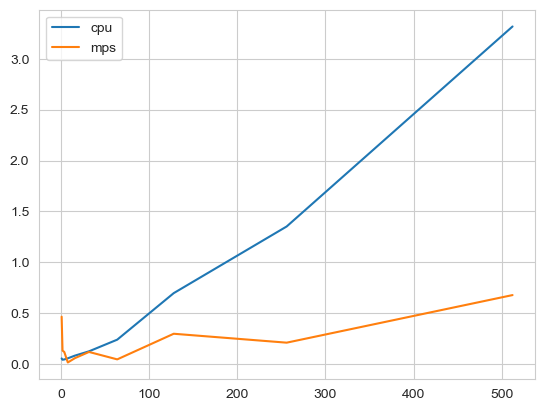

In [27]:
import seaborn as sns

sns.set_style('whitegrid')

sns.lineplot(
    x=[2**i for i in range(b)]*2,
    y=cpu_times+mps_times,
    hue=['cpu']*b + ['mps']*b
)